# Clinical Test model

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact
import ipywidgets as widgets
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from scipy.stats import mode
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import joblib

In [10]:
CT_data = pd.read_csv('../../datasets/Post-Clinical Decision Support/clinical_test_data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

CT_data.head()

,helicobacter_pylori_infection,endoscopic_images,biopsy_results,ct_scan,label
0,0,Normal,Negative,Negative,0
1,1,Normal,Negative,Negative,0
2,0,Normal,Negative,Negative,0
3,1,Normal,Negative,Negative,0
4,0,Abnormal,Negative,Negative,0


In [11]:
# CT_data.drop(columns = 'helicobacter_pylori_infection', inplace = True)

In [12]:
for col in CT_data.columns:
    if col != 'age':
        print("===========================")
        print(CT_data[col].value_counts())

helicobacter_pylori_infection
0    159378
1     52976
Name: count, dtype: int64
endoscopic_images
Normal      148523
Abnormal     63831
Name: count, dtype: int64
biopsy_results
Negative    191223
Positive     21131
Name: count, dtype: int64
ct_scan
Negative    169740
Positive     42614
Name: count, dtype: int64
label
0    191395
1     20959
Name: count, dtype: int64


In [13]:
CT_data['endoscopic_images'] = CT_data['endoscopic_images'].replace({
    'Abnormal': 'Positive',
    'Normal': 'Negative'
})
CT_data.head()

,helicobacter_pylori_infection,endoscopic_images,biopsy_results,ct_scan,label
0,0,Negative,Negative,Negative,0
1,1,Negative,Negative,Negative,0
2,0,Negative,Negative,Negative,0
3,1,Negative,Negative,Negative,0
4,0,Positive,Negative,Negative,0


In [14]:
le = LabelEncoder()

for column in CT_data.columns:
    le.fit(CT_data[column])  # Fit the encoder on the column
    print(f"Classes for column '{column}':")
    
    # Print each class and its corresponding encoded value
    class_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    print(class_mapping)
    print()

Classes for column 'helicobacter_pylori_infection':
{0: 0, 1: 1}

Classes for column 'endoscopic_images':
{'Negative': 0, 'Positive': 1}

Classes for column 'biopsy_results':
{'Negative': 0, 'Positive': 1}

Classes for column 'ct_scan':
{'Negative': 0, 'Positive': 1}

Classes for column 'label':
{0: 0, 1: 1}



In [15]:
for col in ['endoscopic_images', 'biopsy_results', 'ct_scan']:
    CT_data[col] = le.fit_transform(CT_data[col])

CT_data.head()

,helicobacter_pylori_infection,endoscopic_images,biopsy_results,ct_scan,label
0,0,0,0,0,0
1,1,0,0,0,0
2,0,0,0,0,0
3,1,0,0,0,0
4,0,1,0,0,0


In [16]:
# joblib.dump(le, "../../models/Clinical tests/CT_le_encoder.pkl")

['../../models/Clinical tests/CT_le_encoder.pkl']

In [8]:
# # Maybe considering adding new features Bitwise AND between columns biopsy_results and ct_scan
# CT_data['biopsy_results_and_ct_scan'] = CT_data['biopsy_results'] | CT_data['ct_scan']
# # CT_data.drop(columns = ['biopsy_results','ct_scan'], inplace = True)

# CT_data.head()

In [9]:
# print ((CT_data['biopsy_results_and_ct_scan'] & CT_data['label'] == 1).sum())

🧠 Key Insight:
If all features are binary, and we only have 3 features, then:

We have only 8 unique combinations of features possible.

This is extremely low-dimensional and heavily limits the learning capacity of any model.

Even if we have 10,000 samples, we're just repeating the same 8 combinations over and over. No model can do much better than chance if the class distribution within each of those 8 combinations is noisy or unclear.

## Before balancing

In [10]:
combo_stats = CT_data.copy()
label_counts = combo_stats.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)
label_counts

label                                                                       0  \
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan          
0                             0                 0              0        72196   
                                                               1        18180   
                                                1              0         8035   
                                                               1         2024   
                              1                 0              0        31059   
                                                               1         7797   
                                                1              0         3441   
                                                               1          843   
1                             0                 0              0        24051   
                                                               1         6107   
                                                1              0         2647   
                                                               1          639   
                              1                 0              0        10461   
                                                               1         2484   
                                                1              0         1151   
                                                               1          280   

label                                                                      1  
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan        
0                             0                 0              0        7973  
                                                               1        2002  
                                                1              0         842  
                                                               1         239  
                              1                 0              0        3413  
                                                               1         853  
                                                1              0         389  
                                                               1          92  
1                             0                 0              0        2558  
                                                               1         667  
                                                1              0         289  
                                                               1          74  
                              1                 0              0        1122  
                                                               1         300  
                                                1              0         113  
                                                               1          33

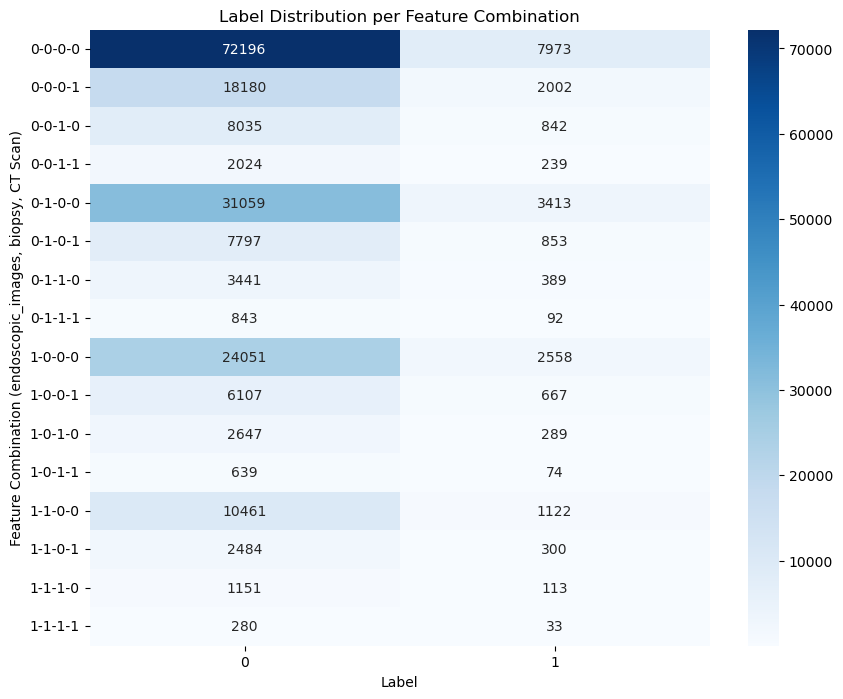

In [11]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (endoscopic_images, biopsy, CT Scan)')
plt.show()

In [12]:
# pca = PCA(n_components=2)
# X_reduced = pca.fit_transform(x_train)

# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap='bwr', alpha = 0.8)
# plt.title("PCA-reduced data")
# plt.show()

In [13]:
# # 2D scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(x_train['endoscopic_images'], x_train['biopsy_results_and_ct_scan'], c=y_train, cmap='bwr', edgecolor='k', alpha=0.7)
# plt.xlabel('endoscopic_images')
# plt.ylabel('biopsy_results_and_ct_scan')
# plt.title('2D Scatter Plot')
# plt.colorbar(label='Label')
# plt.grid(True)
# plt.show()

In [14]:
# # Setup plot
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot
# sc = ax.scatter(
#     x_train['endoscopic_images'], x_train['biopsy_results'], x_train['ct_scan'],
#     c=y_train, cmap='viridis', s=50
# )

# # Axis labels
# ax.set_xlabel('endoscopic_images')
# ax.set_ylabel('biopsy results')
# ax.set_zlabel('CT scan')

# # Color legend
# plt.legend(*sc.legend_elements(), title="Label")
# plt.title("3D Scatter Plot of Features")
# plt.show()

In [15]:
smote_tomek = SMOTETomek(random_state=42)
X, Y = smote_tomek.fit_resample(CT_data,CT_data['label'])

In [16]:
X.drop(columns = 'label', inplace = True)
X.head()

,helicobacter_pylori_infection,endoscopic_images,biopsy_results,ct_scan
0,0,0,0,0
1,1,0,0,0
2,0,0,0,0
3,1,0,0,0
4,0,1,0,0


In [17]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [18]:
Y.value_counts()

label
0    191395
1    191395
Name: count, dtype: int64

In [19]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)
label_counts_resampled

label                                                                       0  \
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan          
0                             0                 0              0        72196   
                                                               1        18180   
                                                1              0         8035   
                                                               1         2024   
                              1                 0              0        31059   
                                                               1         7797   
                                                1              0         3441   
                                                               1          843   
1                             0                 0              0        24051   
                                                               1         6107   
                                                1              0         2647   
                                                               1          639   
                              1                 0              0        10461   
                                                               1         2484   
                                                1              0         1151   
                                                               1          280   

label                                                                       1  
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan         
0                             0                 0              0        72529  
                                                               1        18342  
                                                1              0         7754  
                                                               1         2197  
                              1                 0              0        31115  
                                                               1         7865  
                                                1              0         3498  
                                                               1          842  
1                             0                 0              0        23484  
                                                               1         6008  
                                                1              0         2605  
                                                               1          662  
                              1                 0              0        10410  
                                                               1         2743  
                                                1              0         1028  
                                                               1          313

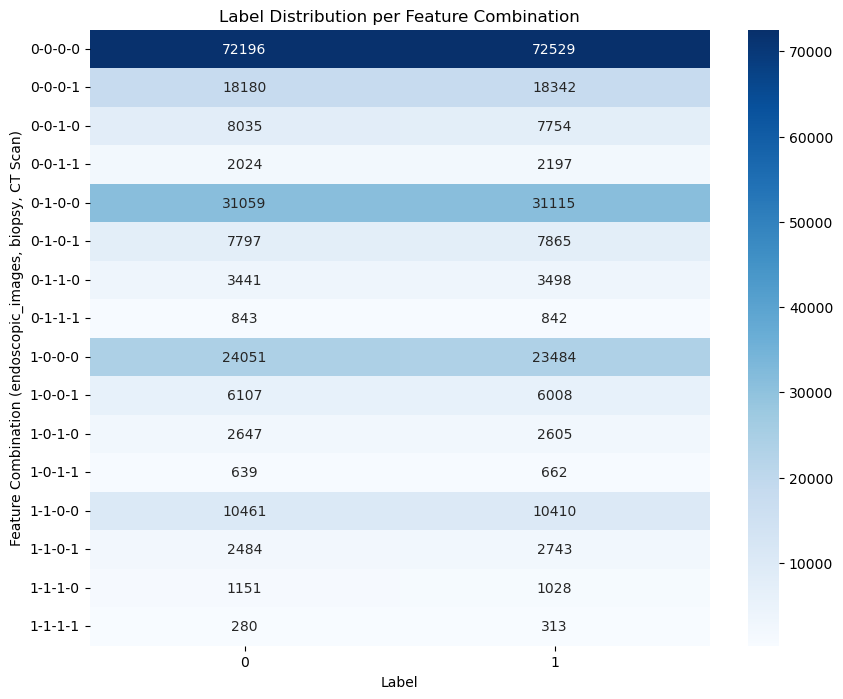

In [20]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (endoscopic_images, biopsy, CT Scan)')
plt.show()

In [21]:
# Identify rows in X_train where all three features are 0
condition0 = (
    (X['helicobacter_pylori_infection'] == 0) &
    (X['endoscopic_images'] == 0) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 0)
)


# Set the corresponding values in y_train to 0
Y.loc[condition0] = 0
Y.loc[(X['biopsy_results'] == 1)] = 1
Y.loc[(X['helicobacter_pylori_infection'] == 1) & (X['endoscopic_images'] == 0) & (X['biopsy_results'] == 0)] = 0

In [22]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)
label_counts_resampled

label                                                                        0  \
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan           
0                             0                 0              0        144725   
                                                               1         18180   
                                                1              0             0   
                                                               1             0   
                              1                 0              0         31059   
                                                               1          7797   
                                                1              0             0   
                                                               1             0   
1                             0                 0              0         47535   
                                                               1         12115   
                                                1              0             0   
                                                               1             0   
                              1                 0              0         10461   
                                                               1          2484   
                                                1              0             0   
                                                               1             0   

label                                                                       1  
helicobacter_pylori_infection endoscopic_images biopsy_results ct_scan         
0                             0                 0              0            0  
                                                               1        18342  
                                                1              0        15789  
                                                               1         4221  
                              1                 0              0        31115  
                                                               1         7865  
                                                1              0         6939  
                                                               1         1685  
1                             0                 0              0            0  
                                                               1            0  
                                                1              0         5252  
                                                               1         1301  
                              1                 0              0        10410  
                                                               1         2743  
                                                1              0         2179  
                                                               1          593

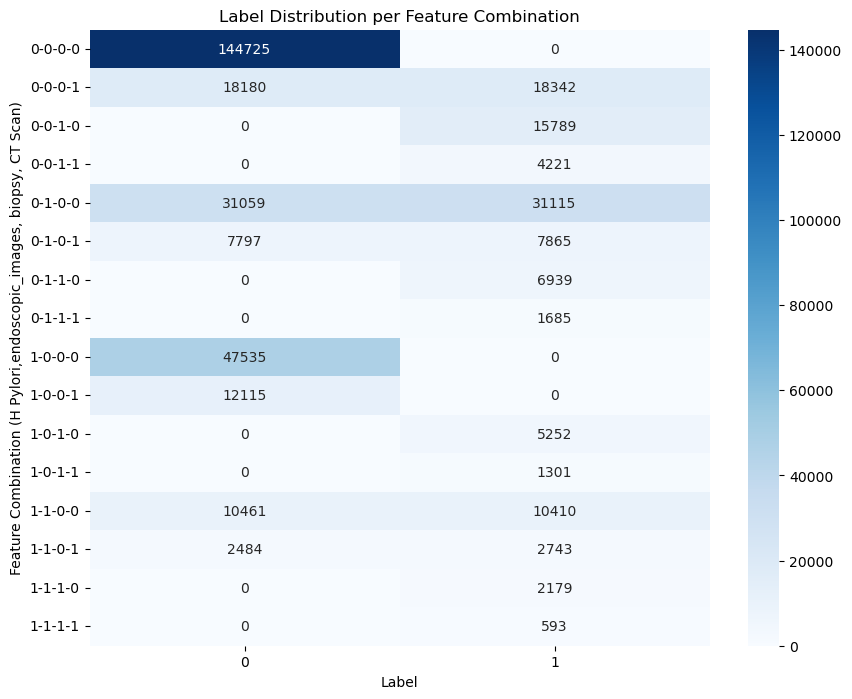

In [23]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [24]:
# Step 1: Define your combination mask
mask_1101 = (
    (X['helicobacter_pylori_infection'] == 1) &
    (X['endoscopic_images'] == 1) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 1) 
)

# Step 2: Get the indices of those rows
indices_1101 = X[mask_1101].index

# Step 3: Shuffle indices
shuffled_indices = indices_1101.to_series().sample(frac=1, random_state=42)


n_total = len(shuffled_indices)
n_positive = int(n_total * 0.89)

Y.loc[shuffled_indices[:n_positive]] = 1
Y.loc[shuffled_indices[n_positive:]] = 0


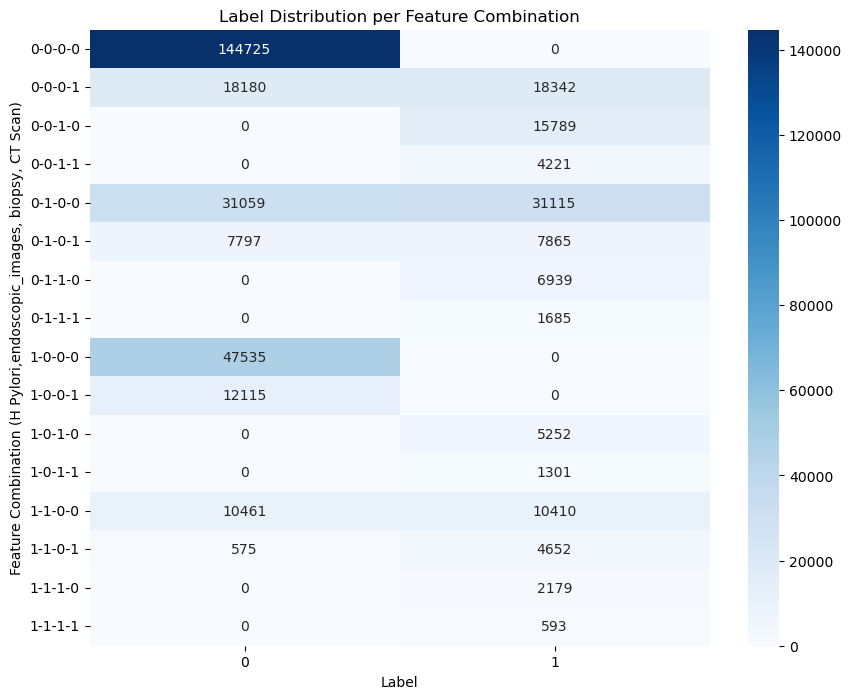

In [25]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [26]:
# Step 1: Define your combination mask
mask = (
    (X['helicobacter_pylori_infection'] == 0) &
    (X['endoscopic_images'] == 0) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 1) 
)

# Step 2: Get the indices of those rows
indices = X[mask].index

# Step 3: Shuffle indices
shuffled_indices = indices.to_series().sample(frac=1, random_state=42)


n_total = len(shuffled_indices)
n_positive = int(n_total * 0.03)

Y.loc[shuffled_indices[:n_positive]] = 1
Y.loc[shuffled_indices[n_positive:]] = 0


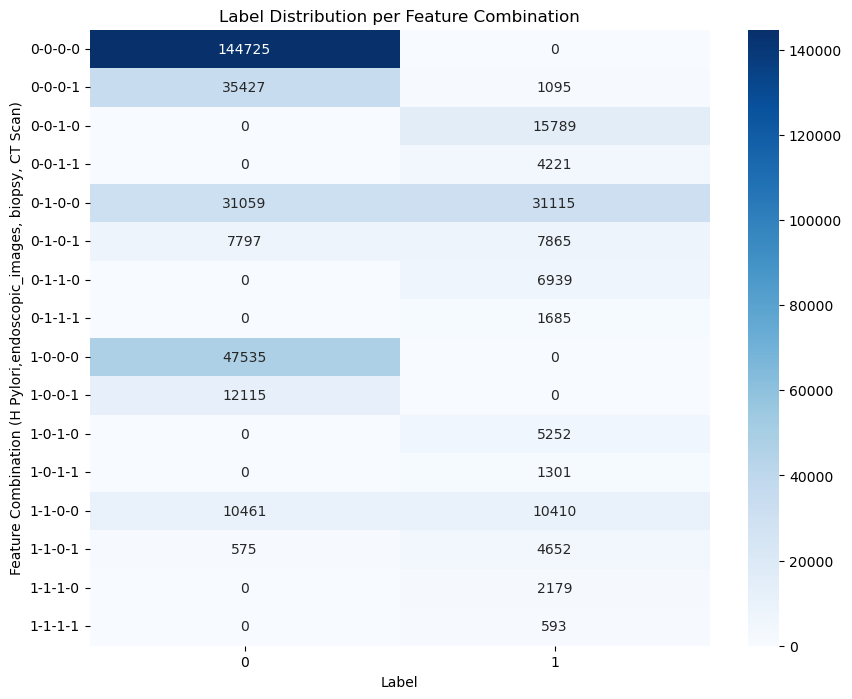

In [27]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [28]:
# Step 1: Define your combination mask
mask = (
    (X['helicobacter_pylori_infection'] == 0) &
    (X['endoscopic_images'] == 1) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 0) 
)

# Step 2: Get the indices of those rows
indices = X[mask].index

# Step 3: Shuffle indices
shuffled_indices = indices.to_series().sample(frac=1, random_state=42)


n_total = len(shuffled_indices)
n_positive = int(n_total * 0.2)

Y.loc[shuffled_indices[:n_positive]] = 1
Y.loc[shuffled_indices[n_positive:]] = 0


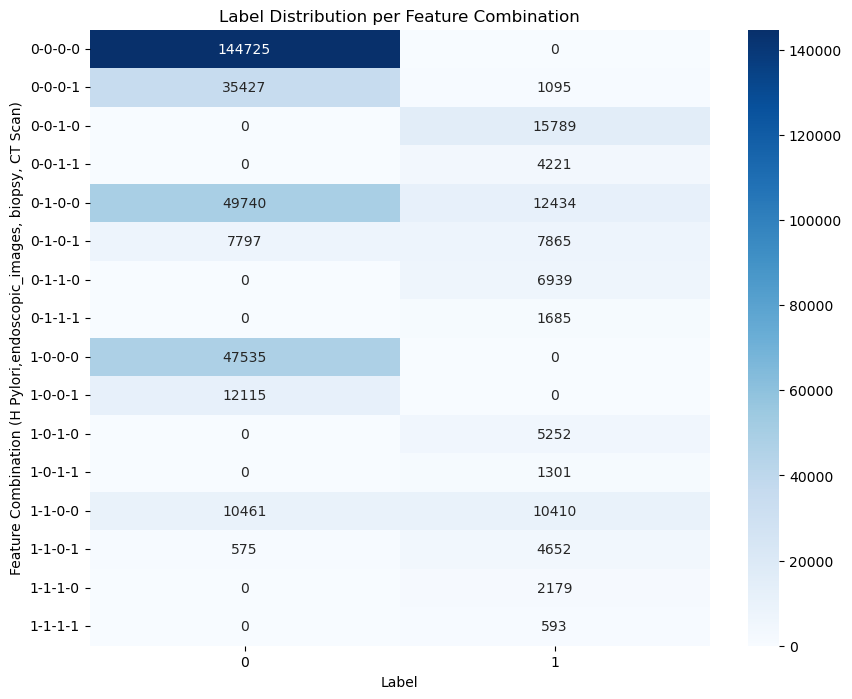

In [29]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [30]:
# Step 1: Define your combination mask
mask = (
    (X['helicobacter_pylori_infection'] == 0) &
    (X['endoscopic_images'] == 1) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 1) 
)

# Step 2: Get the indices of those rows
indices = X[mask].index

# Step 3: Shuffle indices
shuffled_indices = indices.to_series().sample(frac=1, random_state=42)


n_total = len(shuffled_indices)
n_positive = int(n_total * 0.8)

Y.loc[shuffled_indices[:n_positive]] = 1
Y.loc[shuffled_indices[n_positive:]] = 0


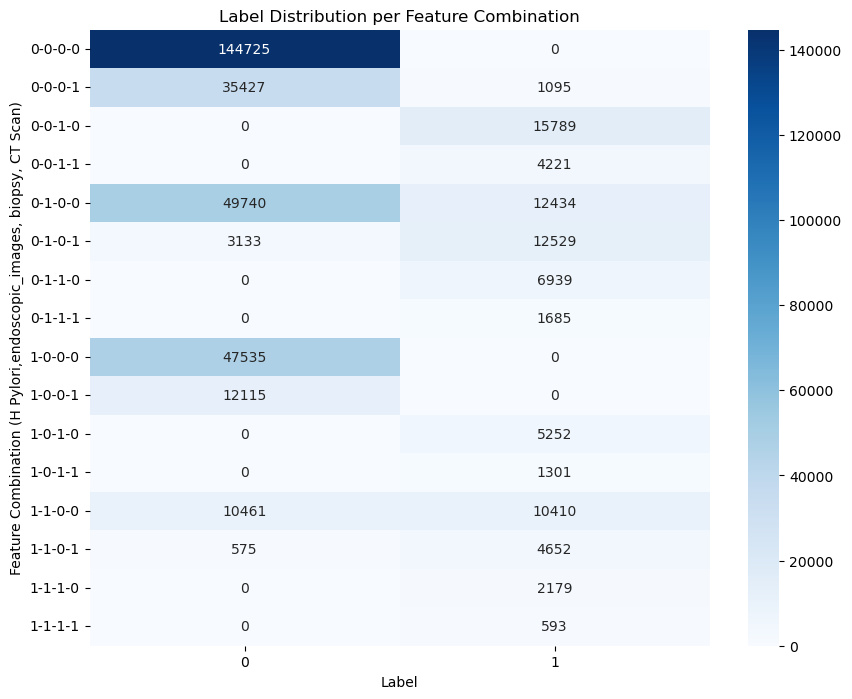

In [31]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [32]:
# Step 1: Define your combination mask
mask = (
    (X['helicobacter_pylori_infection'] == 1) &
    (X['endoscopic_images'] == 1) &
    (X['biopsy_results'] == 0) &
    (X['ct_scan'] == 0) 
)

# Step 2: Get the indices of those rows
indices = X[mask].index

# Step 3: Shuffle indices
shuffled_indices = indices.to_series().sample(frac=1, random_state=42)


n_total = len(shuffled_indices)
n_positive = int(n_total * 0.6)

Y.loc[shuffled_indices[:n_positive]] = 1
Y.loc[shuffled_indices[n_positive:]] = 0


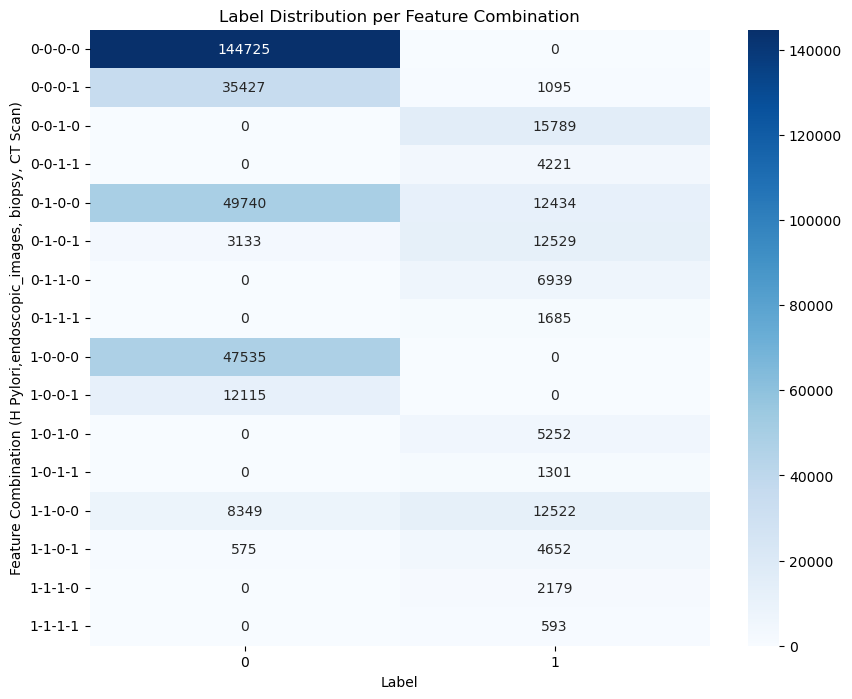

In [33]:
combo_stats_resampled = X.copy()
combo_stats_resampled['label'] = Y
label_counts_resampled = combo_stats_resampled.groupby(['helicobacter_pylori_infection','endoscopic_images', 'biopsy_results', 'ct_scan'])['label'].value_counts().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(label_counts_resampled, annot=True, cmap='Blues', fmt='d')
plt.title('Label Distribution per Feature Combination')
plt.xlabel('Label')
plt.ylabel('Feature Combination (H Pylori,endoscopic_images, biopsy, CT Scan)')
plt.show()

In [34]:
X.isnull().sum()

helicobacter_pylori_infection    0
endoscopic_images                0
biopsy_results                   0
ct_scan                          0
dtype: int64

In [35]:
# Splitting the data to 30% test and 70% train for now
x_train, x_temp, y_train, y_temp = train_test_split(X,Y, test_size = 0.3, random_state = 42, stratify = Y)


# Split that 30% into 15% validation and 15% test (i.e., 50% of 30%)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [36]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(267953, 4)
(57418, 4)
(57419, 4)
(267953,)
(57418,)
(57419,)


In [37]:
# # Combine features and labels (assuming x_train and y_train are separate)
# train_df = pd.concat([x_train, y_train], axis=1)

# # Separate majority and minority classes
# majority_class = train_df[train_df['label'] == 0]
# minority_class = train_df[train_df['label'] == 1]

# # Downsample majority class
# majority_downsampled = resample(majority_class,
#                                 replace=False,               # without replacement
#                                 n_samples=len(minority_class),  # match minority class
#                                 random_state=42)

# # Combine minority class with downsampled majority
# downsampled_df = pd.concat([minority_class, majority_downsampled])

# # Shuffle the dataset
# downsampled_df = downsampled_df.sample(frac=1, random_state=42)

# # Split back into features and labels
# x_train_downsampled = downsampled_df.drop('label', axis=1)
# y_train_downsampled = downsampled_df['label']

In [38]:
# y_train_downsampled.value_counts()

In [39]:
# # Combine features and labels (assuming x_train and y_train are separate)
# train_df = pd.concat([x_val, y_val], axis=1)

# # Separate majority and minority classes
# majority_class = train_df[train_df['label'] == 0]
# minority_class = train_df[train_df['label'] == 1]

# # Downsample majority class
# majority_downsampled = resample(majority_class,
#                                 replace=False,               # without replacement
#                                 n_samples=len(minority_class),  # match minority class
#                                 random_state=42)

# # Combine minority class with downsampled majority
# downsampled_df = pd.concat([minority_class, majority_downsampled])

# # Shuffle the dataset
# downsampled_df = downsampled_df.sample(frac=1, random_state=42)

# # Split back into features and labels
# x_val_downsampled = downsampled_df.drop('label', axis=1)
# y_val_downsampled = downsampled_df['label']

In [40]:
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth = 4),
    n_estimators=100
)
model.fit(x_train, y_train)

/usr/lib/python3/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=100)

In [41]:
# model = RandomForestClassifier(class_weight='balanced')
# model.fit(x_resampled, y_resampled)

==================== accuracy on val
Evaluation Results:
Accuracy:  0.9319
Precision: 0.8461
Recall:    0.8295
F1 Score:  0.8377
==================== accuracy on train
Evaluation Results:
Accuracy:  0.9336
Precision: 0.8494
Recall:    0.8349
F1 Score:  0.8421


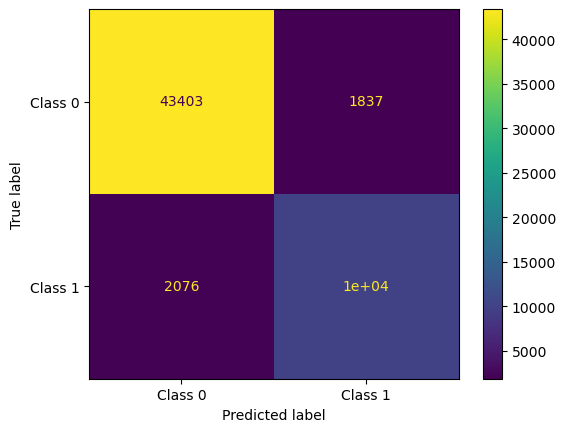

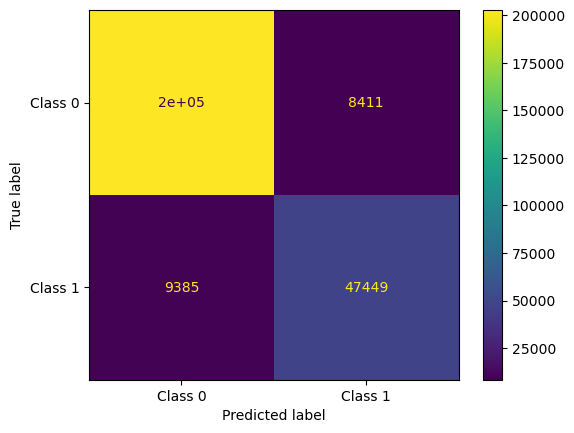

In [42]:
y_pred = model.predict(x_val)

print('==================== accuracy on val')
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Evaluation Results:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

print('==================== accuracy on train')

y_pred = model.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("Evaluation Results:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot()

In [43]:
# import joblib

# # Save the model to a file
# joblib.dump(model, '../../models/Clinical tests/Clinical tests.pkl')

['../../models/Clinical tests/Clinical tests.pkl']

In [45]:
# import pickle

# # Assuming model3 is already trained
# filename = '../../models/Clinical tests/Clinical tests_.sav'

# # Save the trained model using pickle
# with open(filename, 'wb') as file:
#     pickle.dump(model, file)

# print("Model saved successfully!")

Model saved successfully!
